In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from scipy.stats import shapiro
from scipy.stats import kruskal
from scipy.stats import levene
from scipy.stats import spearmanr, pearsonr
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu
from scipy.stats import linregress

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

import warnings
warnings.simplefilter(action='ignore', category=Warning)


In [2]:
water_df= pd.read_csv('/Users/alexgrant/Downloads/water_pollution_disease.csv')
water_df.head()

,Country,Region,Year,Water Source Type,Contaminant Level (ppm),pH Level,Turbidity (NTU),Dissolved Oxygen (mg/L),Nitrate Level (mg/L),Lead Concentration (µg/L),...,"Cholera Cases per 100,000 people","Typhoid Cases per 100,000 people","Infant Mortality Rate (per 1,000 live births)",GDP per Capita (USD),Healthcare Access Index (0-100),Urbanization Rate (%),Sanitation Coverage (% of Population),Rainfall (mm per year),Temperature (°C),Population Density (people per km²)
0,Mexico,North,2015,Lake,6.06,7.12,3.93,4.28,8.28,7.89,...,33,44,76.16,57057,96.92,84.61,63.23,2800,4.94,593
1,Brazil,West,2017,Well,5.24,7.84,4.79,3.86,15.74,14.68,...,27,8,77.30,17220,84.73,73.37,29.12,1572,16.93,234
2,Indonesia,Central,2022,Pond,0.24,6.43,0.79,3.42,36.67,9.96,...,39,50,48.45,86022,58.37,72.86,93.56,2074,21.73,57
3,Nigeria,East,2016,Well,7.91,6.71,1.96,3.12,36.92,6.77,...,33,13,95.66,31166,39.07,71.07,94.25,937,3.79,555
4,Mexico,South,2005,Well,0.12,8.16,4.22,9.15,49.35,12.51,...,31,68,58.78,25661,23.03,55.55,69.23,2295,31.44,414


In [3]:
water_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 24 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Country                                        3000 non-null   object 
 1   Region                                         3000 non-null   object 
 2   Year                                           3000 non-null   int64  
 3   Water Source Type                              3000 non-null   object 
 4   Contaminant Level (ppm)                        3000 non-null   float64
 5   pH Level                                       3000 non-null   float64
 6   Turbidity (NTU)                                3000 non-null   float64
 7   Dissolved Oxygen (mg/L)                        3000 non-null   float64
 8   Nitrate Level (mg/L)                           3000 non-null   float64
 9   Lead Concentration (µg/L)                      3000 

In [4]:
water_df.isnull().sum()

Country                                            0
Region                                             0
Year                                               0
Water Source Type                                  0
Contaminant Level (ppm)                            0
pH Level                                           0
Turbidity (NTU)                                    0
Dissolved Oxygen (mg/L)                            0
Nitrate Level (mg/L)                               0
Lead Concentration (µg/L)                          0
Bacteria Count (CFU/mL)                            0
Water Treatment Method                           747
Access to Clean Water (% of Population)            0
Diarrheal Cases per 100,000 people                 0
Cholera Cases per 100,000 people                   0
Typhoid Cases per 100,000 people                   0
Infant Mortality Rate (per 1,000 live births)      0
GDP per Capita (USD)                               0
Healthcare Access Index (0-100)               

## Data Quality
###### 747 missing values is high

In [5]:
missing= water_df[water_df['Water Treatment Method'].isnull()]
missing['Region'].value_counts().head()

Region
East       160
North      155
Central    152
West       143
South      137
Name: count, dtype: int64

In [6]:
missing['Country'].value_counts().head(10)

Country
Nigeria       89
USA           87
Indonesia     82
Pakistan      79
Brazil        75
China         73
Mexico        72
Ethiopia      65
India         63
Bangladesh    62
Name: count, dtype: int64

#### most of the missing data comes from countries with higher social inequality. since the data are concentrated to those regions, i will assign 'unknown' to them

In [7]:
water_df['Water Treatment Method'] = water_df.groupby('Country')['Water Treatment Method']\
    .transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else 'Unknown'))

In [8]:
water_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 24 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Country                                        3000 non-null   object 
 1   Region                                         3000 non-null   object 
 2   Year                                           3000 non-null   int64  
 3   Water Source Type                              3000 non-null   object 
 4   Contaminant Level (ppm)                        3000 non-null   float64
 5   pH Level                                       3000 non-null   float64
 6   Turbidity (NTU)                                3000 non-null   float64
 7   Dissolved Oxygen (mg/L)                        3000 non-null   float64
 8   Nitrate Level (mg/L)                           3000 non-null   float64
 9   Lead Concentration (µg/L)                      3000 

In [9]:
water_df.duplicated().sum()

np.int64(0)

##### After cleaning and processing hte dataset, I decided to focus the analysis on Mexico to explore regional disparities in public health indicators and their association with water quality factors

In [10]:
mexico_df= water_df[water_df['Country']== 'Mexico']

In [11]:
mexico_df.head()

,Country,Region,Year,Water Source Type,Contaminant Level (ppm),pH Level,Turbidity (NTU),Dissolved Oxygen (mg/L),Nitrate Level (mg/L),Lead Concentration (µg/L),...,"Cholera Cases per 100,000 people","Typhoid Cases per 100,000 people","Infant Mortality Rate (per 1,000 live births)",GDP per Capita (USD),Healthcare Access Index (0-100),Urbanization Rate (%),Sanitation Coverage (% of Population),Rainfall (mm per year),Temperature (°C),Population Density (people per km²)
0,Mexico,North,2015,Lake,6.06,7.12,3.93,4.28,8.28,7.89,...,33,44,76.16,57057,96.92,84.61,63.23,2800,4.94,593
4,Mexico,South,2005,Well,0.12,8.16,4.22,9.15,49.35,12.51,...,31,68,58.78,25661,23.03,55.55,69.23,2295,31.44,414
7,Mexico,Central,2024,Spring,3.76,6.42,1.35,9.99,2.73,19.44,...,0,10,67.30,76593,7.27,45.22,70.22,940,19.64,111
28,Mexico,Central,2000,Lake,0.32,6.34,0.33,8.42,24.14,3.01,...,37,72,80.39,84224,17.49,77.38,74.06,1560,39.39,528
34,Mexico,East,2007,Well,7.27,6.15,1.86,6.05,31.54,6.16,...,38,76,19.49,82551,83.78,31.20,54.42,290,36.42,503


In [12]:
mexico_df.isnull().sum()

Country                                          0
Region                                           0
Year                                             0
Water Source Type                                0
Contaminant Level (ppm)                          0
pH Level                                         0
Turbidity (NTU)                                  0
Dissolved Oxygen (mg/L)                          0
Nitrate Level (mg/L)                             0
Lead Concentration (µg/L)                        0
Bacteria Count (CFU/mL)                          0
Water Treatment Method                           0
Access to Clean Water (% of Population)          0
Diarrheal Cases per 100,000 people               0
Cholera Cases per 100,000 people                 0
Typhoid Cases per 100,000 people                 0
Infant Mortality Rate (per 1,000 live births)    0
GDP per Capita (USD)                             0
Healthcare Access Index (0-100)                  0
Urbanization Rate (%)          

#### The importance of correlating environmental and health variables

##### Understanding the relationship between the environment and public health is essential for developing effective policies and interventions. By correlating environmental variables such as water quality indicators with health indicators, researchers and policymakers can identify patterns and risk factors.

##### This type of analysis provides evidence-based insights that help prioritize resources to improve health infrastructure and enhance access to clean water. It highlights vulnerable regions where targeted actions may significantly reduce disease and improve health conditions.

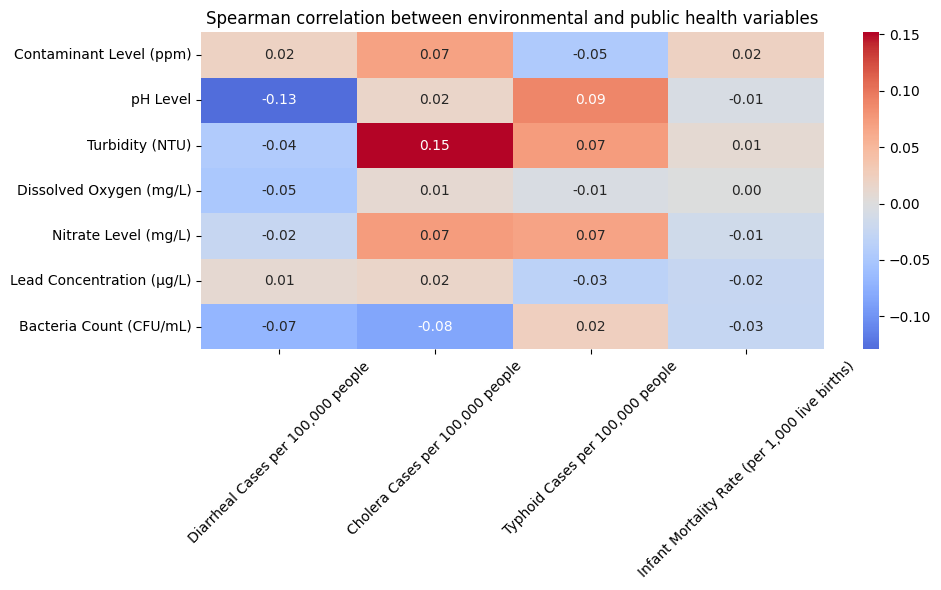

In [13]:
environmental_vars= [
    'Contaminant Level (ppm)',
    'pH Level',
    'Turbidity (NTU)',
    'Dissolved Oxygen (mg/L)',
    'Nitrate Level (mg/L)',
    'Lead Concentration (µg/L)',
    'Bacteria Count (CFU/mL)'
]

health_vars= [
    'Diarrheal Cases per 100,000 people',
    'Cholera Cases per 100,000 people',
    'Typhoid Cases per 100,000 people',
    'Infant Mortality Rate (per 1,000 live births)'
]

correlations= pd.DataFrame(index=environmental_vars, columns=health_vars)

for env_var in environmental_vars:
    for health_var in health_vars:
        coef, _= spearmanr(mexico_df[env_var], mexico_df[health_var])
        correlations.loc[env_var, health_var]= coef

correlations= correlations.astype(float)

plt.figure(figsize=(10, 6))
sns.heatmap(correlations, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Spearman correlation between environmental and public health variables")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Analyzing the Relationship between Cholera Cases and Turbidity

##### To explore the impact of cloudy or contaminated water on public health, I investigate the relationship between Turbidity (NTU) and Cholera Cases per 100,000 people in Mexico. Using Spearman's rank correlation, we assessed whether there is a monotonic association between these two varibales.

##### The code below calculates the correlation coefficient and visualizes the relationship through a scatter plot with a trend line. This can help us describe how turbidity might be linked to the prevalence of cholera, supporting the hypothesis that poor water quality can significantly affect health outcomes.

Spearman correlation: coef= 0.1519, p-valor= 0.0098


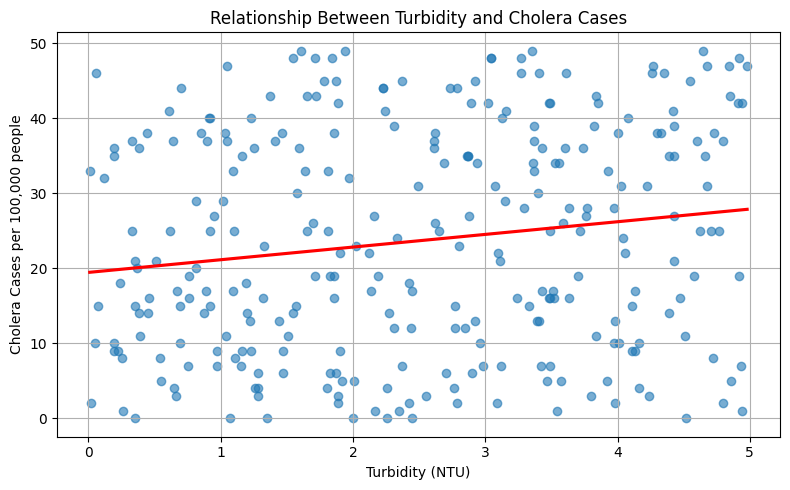

In [14]:
x= mexico_df['Turbidity (NTU)']
y= mexico_df['Cholera Cases per 100,000 people']

coef, pval= spearmanr(x,y)
print(f"Spearman correlation: coef= {coef:.4f}, p-valor= {pval:.4f}")

plt.figure(figsize=(8,5))
sns.regplot(x=x, y=y, scatter_kws={'alpha':0.6}, line_kws={'color':'red'}, ci=None)
plt.title('Relationship Between Turbidity and Cholera Cases')
plt.xlabel('Turbidity (NTU)')
plt.ylabel('Cholera Cases per 100,000 people')
plt.grid(True)
plt.tight_layout()
plt.show()

### Interpretation
##### The spearman correlation coefficient between Turbidity (NTU) and Cholera Cases per 100,000 people is 0.1519 with a p-value of 0.0098. This suggests there is a weak but statistically significant positive correlation. In other words, as the turbidity of the water increases, cholera cases tend to slightly increase as well.

##### Although the correlation is not strong, the low p-value indicates that the relationship is unlikely due to random chance. This highlights the potential role of cloudy water in contributing to cholera (a waterborne disease) and emphasizes the importance of monitoring and improving water quality to improve public health.

### Analyzing regional patterns of Turbidity
##### To better understand water turbidity across different regions of Mexico, the data is grouped by region below and the average was calculated. This helps analyze which regions typically experience higher turbidity in water sources, which can be a critical factor in the spread of waterborne diseases. The results are presented both in a table and in a bar chart for easier comparison and interpretation.

Average Turbidity by Region:
Region
North      2.721270
South      2.656304
West       2.472344
East       2.350526
Central    2.246207
Name: Turbidity (NTU), dtype: float64


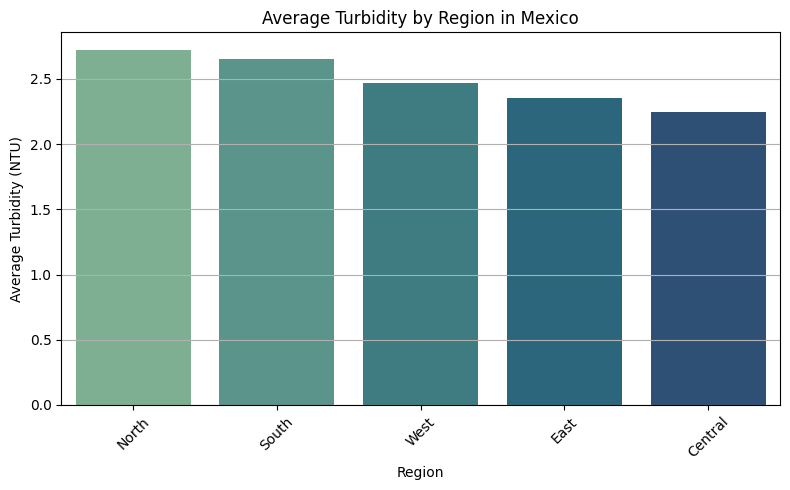

In [15]:
turbidity_by_reg= mexico_df.groupby('Region')['Turbidity (NTU)'].mean().sort_values(ascending=False) #group by region
print('Average Turbidity by Region:')
print(turbidity_by_reg)

#graph
plt.figure(figsize=(8,5))
sns.barplot(x=turbidity_by_reg.index,y=turbidity_by_reg.values, palette= 'crest')
plt.title('Average Turbidity by Region in Mexico')
plt.ylabel('Average Turbidity (NTU)')
plt.xlabel('Region')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [16]:
from scipy.stats import zscore

#determine if there are any outliers in the Turbidity feature using zscore
outliers = mexico_df[(zscore(mexico_df['Turbidity (NTU)']).abs() > 3)]
outliers

,Country,Region,Year,Water Source Type,Contaminant Level (ppm),pH Level,Turbidity (NTU),Dissolved Oxygen (mg/L),Nitrate Level (mg/L),Lead Concentration (µg/L),...,"Cholera Cases per 100,000 people","Typhoid Cases per 100,000 people","Infant Mortality Rate (per 1,000 live births)",GDP per Capita (USD),Healthcare Access Index (0-100),Urbanization Rate (%),Sanitation Coverage (% of Population),Rainfall (mm per year),Temperature (°C),Population Density (people per km²)


### Conclusion
##### The results indicate the the North region of Mexico has the highest average turbidity (2.721 NTU), followed closely by the South (2.656 NTU). In contrast, the Central region has the lowest average turbidity (2.246 NTU). Additionally, no outliers were found in the data which may have heavily affected the mean of these regions. This suggests a regional disparity in water quality between the north and south in comparison with the central. The north and south may be potentially facing greater public health risks, highlighting the need for targeted public health interventions and improved water treatment infrastructure in the most affected regions.

### Water source North region

##### To gain a deeper insight into regional water quality and its potential public health disparities, I focused on the North region of Mexico. I analyzed the most commonly used water sources and compared their average turbidities. This helps to identify which bodies of water types may pose greater threats to public health.

Most common water sources in the North region:
Water Source Type
Tap       15
Lake      10
Pond      10
Well      10
Spring    10
River      8
Name: count, dtype: int64

Average Turbidity by Water Source Type in the North Region:
Water Source Type
River     3.76875
Pond      3.06500
Tap       2.94800
Well      2.46600
Spring    2.12500
Lake      2.05100
Name: Turbidity (NTU), dtype: float64


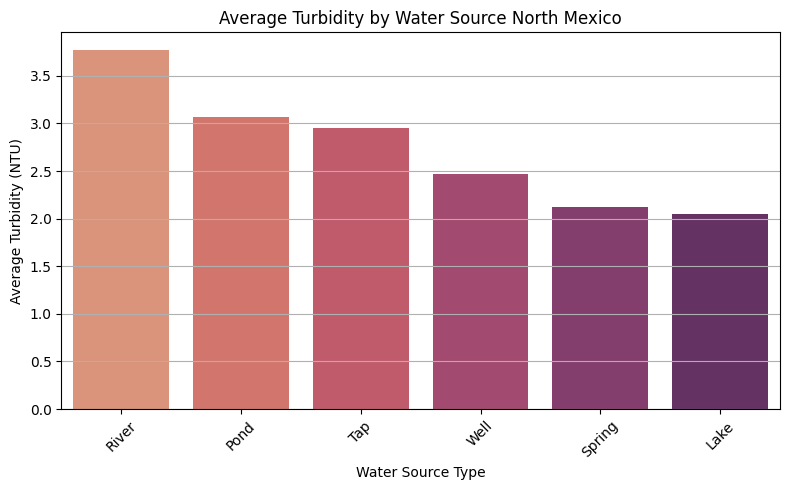

In [17]:
north_df= mexico_df[mexico_df['Region']=='North']

most_common_source= north_df['Water Source Type'].value_counts()
print('Most common water sources in the North region:')
print(most_common_source)

turbidity_by_source= north_df.groupby('Water Source Type')['Turbidity (NTU)'].mean().sort_values(ascending=False)
print('\nAverage Turbidity by Water Source Type in the North Region:')
print(turbidity_by_source)

plt.figure(figsize=(8,5))
sns.barplot(x=turbidity_by_source.index, y= turbidity_by_source.values, palette= 'flare')
plt.title('Average Turbidity by Water Source North Mexico')
plt.xlabel('Water Source Type')
plt.ylabel('Average Turbidity (NTU)')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

### Conclusion:
##### The analysis revealed that taps are the most commonly used source in the North region of Mexico. However, rivers high the highest average turbidity of (3.769 NTU) with nothing nearly as high. These findings highlight that frequently used sources are not necessarily the cleanest and that natural sources (rivers) require stronger monitoring or treatment efforts to ensure higher public health standards.

### The relationship between Turbidity and Infant Mortality
##### To further investigate potential public health implications of water clarity, a correlation analysis is conducted below between the turbidity and infant mortality rate in the North region of Mexico. This aims to explore wehter higher turbidity in water sources are associated with incresed infant mortality, a critical health indicator. The analysis includes normality testing and the use of Spearman's correlation, considering the distribution of the data.

In [18]:
x= north_df['Turbidity (NTU)']
y= north_df['Infant Mortality Rate (per 1,000 live births)']

#shapiro test used to test for normality of data
shapiro_x= shapiro(x)
shapiro_y= shapiro(y)
print(f'Shapiro_Wilk for Turbidity: Statistics= {shapiro_x.statistic:.4f}, p-value= {shapiro_x.pvalue:.4f}')
print(f'Shapiro_Wilk for Infant Mortality: Statistics= {shapiro_y.statistic:.4f}, p-value= {shapiro_y.pvalue:.4f}')

coef, pval = spearmanr(x, y)
print(f"\nSpearman correlation: coef = {coef:.4f}, p-valor = {pval:.4f}")

Shapiro_Wilk for Turbidity: Statistics= 0.9500, p-value= 0.0123
Shapiro_Wilk for Infant Mortality: Statistics= 0.9638, p-value= 0.0605

Spearman correlation: coef = 0.0012, p-valor = 0.9924


### Conclusion
##### The Shapiro-Wilk indicated that both variable deviate from normal distribution. Therefore, Spearman's rank correlation was used. The correlation analysis between Bacteria Count and Infant Mortality Rate in the North region resulted in a week positive correlation with a p-value of 0.9924. This suggests that there is no statistically significant relationship between turbidity and infant mortality rate in this region based on the data.
### Region Means
##### To better understand the regional disparities in public health outcomes, I calculated the average values of four key health indicators––Diarrheal Cases, Cholera Cases, Typhoid Cases, and Infant Mortality Rate––for each region in Mexico. By aggregating the data by region, this analysis aims to identify which areas are more impacted by waterborne diseases and infant health challenges.

In [19]:
impact_vars= [
    'Diarrheal Cases per 100,000 people',
    'Cholera Cases per 100,000 people',
    'Typhoid Cases per 100,000 people',
    'Infant Mortality Rate (per 1,000 live births)'
]

region_means= mexico_df.groupby('Region')[impact_vars].mean().round(2)
region_means

,"Diarrheal Cases per 100,000 people","Cholera Cases per 100,000 people","Typhoid Cases per 100,000 people","Infant Mortality Rate (per 1,000 live births)"
Region,,,,
Central,299.60,24.02,48.66,54.72
East,277.84,21.44,48.04,53.51
North,251.32,26.32,44.05,47.18
South,227.98,25.35,50.13,43.95
West,240.53,21.44,49.08,49.14


### Conclusion
##### The results show that the Central region reports the highest average cases of Diarrhea (299.60) and it also has the highest Infant Mortality Rate (54.72) per 1,000 live births. Below I will investigate the relationship between Diarrheal cases and IMR.

In [20]:
x= north_df['Diarrheal Cases per 100,000 people']
y= north_df['Infant Mortality Rate (per 1,000 live births)']

#shapiro test used to test for normality of data
shapiro_x= shapiro(x)
shapiro_y= shapiro(y)
print(f'Shapiro_Wilk for Diarrheal Cases: Statistics= {shapiro_x.statistic:.4f}, p-value= {shapiro_x.pvalue:.4f}')
print(f'Shapiro_Wilk for Infant Mortality: Statistics= {shapiro_y.statistic:.4f}, p-value= {shapiro_y.pvalue:.4f}')

coef, pval = spearmanr(x, y)
print(f"\nSpearman correlation: coef = {coef:.4f}, p-valor = {pval:.4f}")

Shapiro_Wilk for Diarrheal Cases: Statistics= 0.9637, p-value= 0.0600
Shapiro_Wilk for Infant Mortality: Statistics= 0.9638, p-value= 0.0605

Spearman correlation: coef = 0.1066, p-valor = 0.4057


### Conclusion:
##### There is no statistically significant correlation between diarrheal cases and IMR. This suggests the public health outcomes are not evenly/uniformly distributed and may be influenced by multiple factors beyond waterborne disease exposure, such as access to healthcare, sanitation infrastructure, and socio-economic conditions.

### Distribution of Health Indicators by Region in Mexico

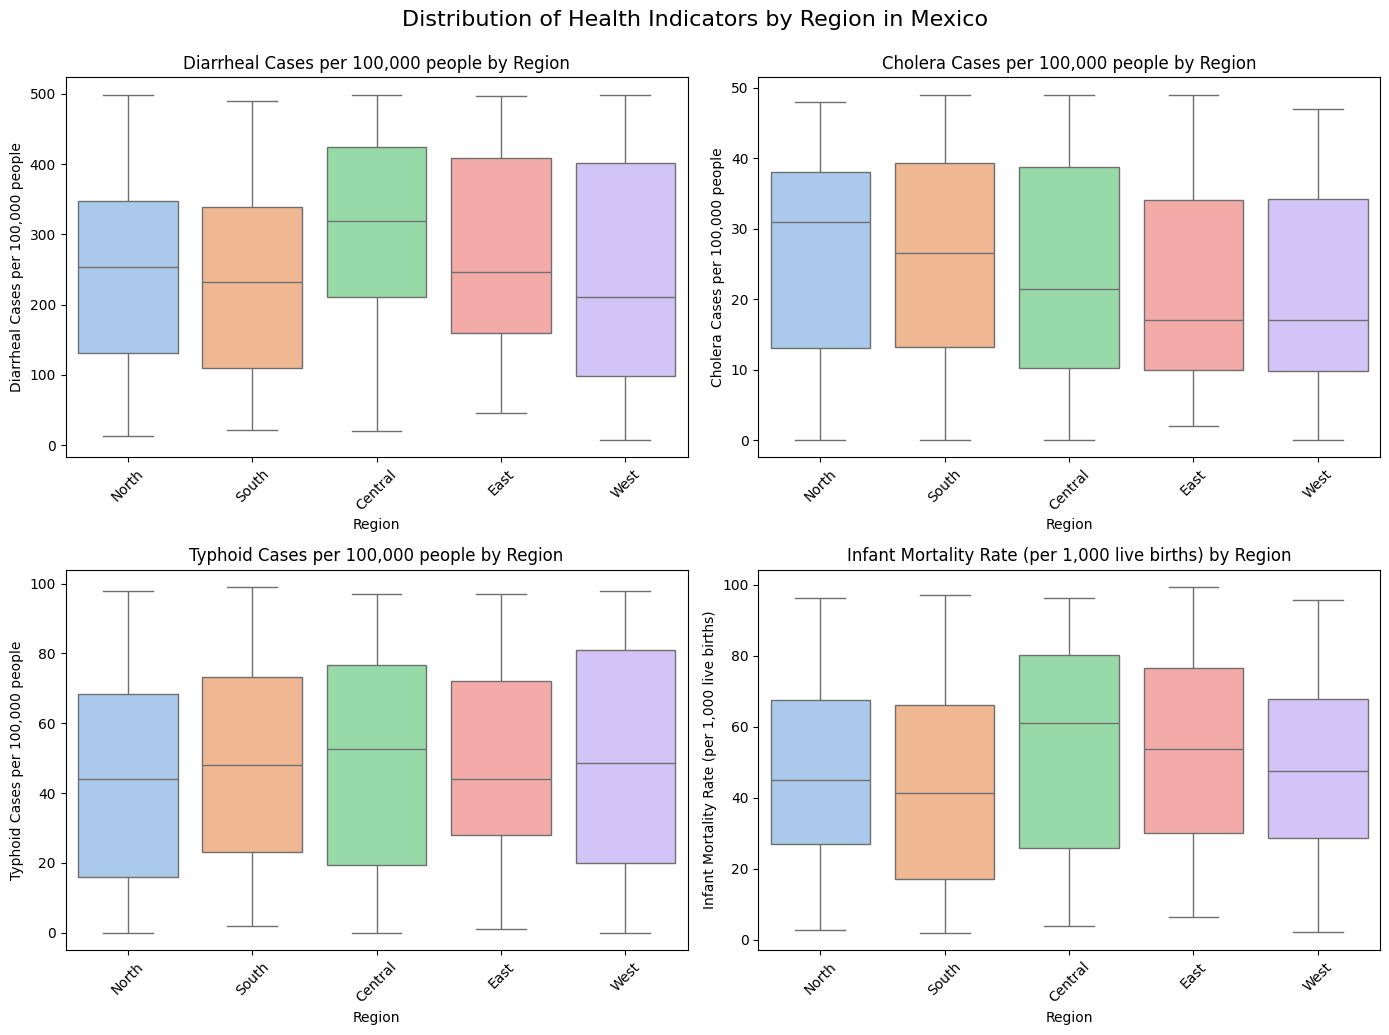

In [23]:
health_vars= [
    'Diarrheal Cases per 100,000 people',
    'Cholera Cases per 100,000 people',
    'Typhoid Cases per 100,000 people',
    'Infant Mortality Rate (per 1,000 live births)'
]

plt.figure(figsize=(14,10))

for i, var in enumerate(health_vars,1):
    plt.subplot(2,2,i)
    sns.boxplot(data=mexico_df, x='Region', y=var, palette= 'pastel')
    plt.title(f'{var} by Region')
    plt.xticks(rotation=45)
    plt.tight_layout()

plt.suptitle('Distribution of Health Indicators by Region in Mexico', fontsize=16, y=1.03)
plt.show()

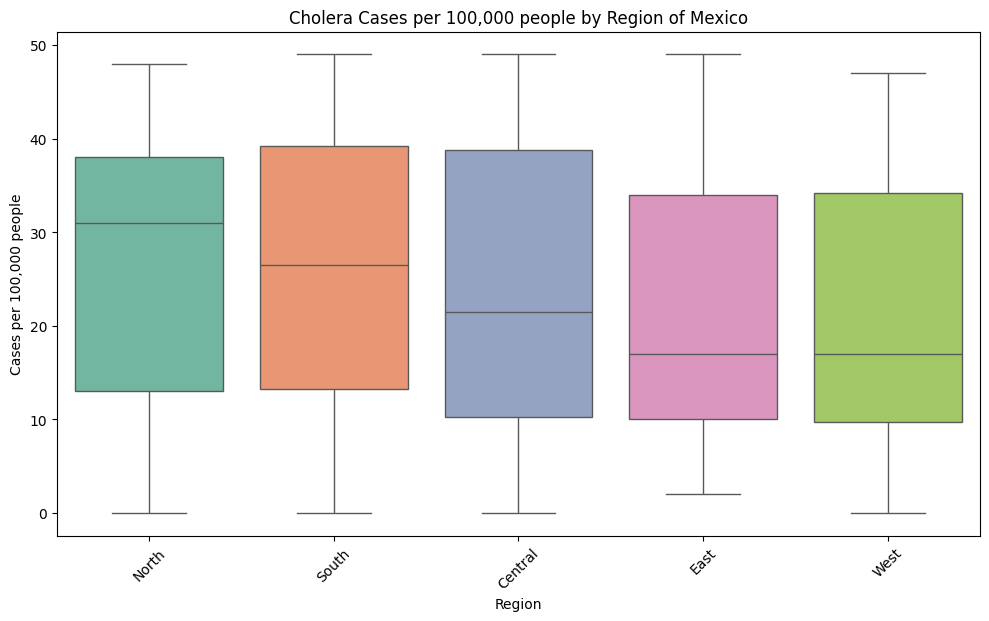

In [24]:
plt.figure(figsize=(10,6))
sns.boxplot(data= mexico_df, x='Region', y='Cholera Cases per 100,000 people', palette ='Set2')
plt.ylabel('Cases per 100,000 people')
plt.xlabel('Region')
plt.title('Cholera Cases per 100,000 people by Region of Mexico')
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()

In [25]:
regions= mexico_df['Region'].unique()
cholera_by_region= {
    region: mexico_df[mexico_df['Region']== region]['Cholera Cases per 100,000 people']
    for region in regions
}

#normality test
print('Shapiro-Wilk test by region:')
for region, data in cholera_by_region.items():
    stat, p= shapiro(data)
    print(f'{region:<10} - Statistic: {stat:.4f}, p-value: {p:.4f}')

print('\nKruskal-Wallis test:')
kruskal_result= kruskal(*cholera_by_region.values())
print(f'Statistic: {kruskal_result.statistic:.4f}, p-value: {kruskal_result.pvalue:.4f}')
    

Shapiro-Wilk test by region:
North      - Statistic: 0.9143, p-value: 0.0003
South      - Statistic: 0.9381, p-value: 0.0167
Central    - Statistic: 0.9248, p-value: 0.0015
East       - Statistic: 0.9353, p-value: 0.0045
West       - Statistic: 0.9354, p-value: 0.0023

Kruskal-Wallis test:
Statistic: 4.9416, p-value: 0.2933


### Conclusion
##### The shapiro-wilk test results show that regional distributions deviate from normality with p-values below 0.05. I used the kruskal-wallace test because of non-normal distribution, but the p-value was 0.2933, suggesting that the distributions of cholera cases across regions are not significant at the 5% level. While regional variations exist visually, they are not different enough to conclude a meaninful difference in the median values.

### Regional Distribution of Typhoid Cases in Mexico
##### This analysis aims to examine the distribution of typhoid cases per 100,000 people across different regions in Mexico. A boxplot was used to visualize regional variations. The shapiro_wilk test was applied to test for normality of the data, and then the kruskal-wallis test was used as a non-parametric alternative to ANOVA to test for significant differences among the regions.

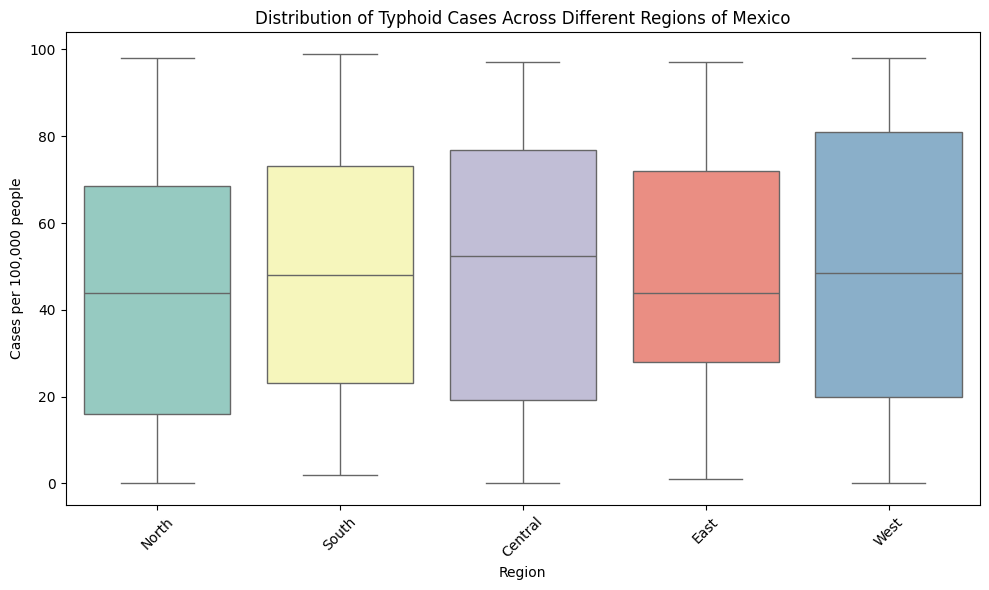

In [26]:
plt.figure(figsize=(10,6))
sns.boxplot(data=mexico_df, x='Region', y='Typhoid Cases per 100,000 people', palette= 'Set3')
plt.title('Distribution of Typhoid Cases Across Different Regions of Mexico')
plt.xlabel('Region')
plt.xticks(rotation=45)
plt.ylabel('Cases per 100,000 people')
plt.tight_layout()
plt.show()

In [28]:
regions= mexico_df['Region'].unique()
print('Shapiro-Wilk test by region:')
for region in regions:
    regional_data= mexico_df[mexico_df['Region']==region]['Typhoid Cases per 100,000 people']
    stat, p= shapiro(regional_data)
    print(f'{region:<10} - Statistic: {stat:.4f}, p-value: {p:.4f}')

grouped_data= [mexico_df[mexico_df['Region']== region]['Typhoid Cases per 100,000 people'] for region in regions]

kruskal_stat, kruskal_p= kruskal(*grouped_data)
print(f'\nKruskal_Wallis test:')
print(f'Statistic: {kruskal_stat:.4f}, p-value: {kruskal_p:.4f}')

Shapiro-Wilk test by region:
North      - Statistic: 0.9412, p-value: 0.0047
South      - Statistic: 0.9497, p-value: 0.0458
Central    - Statistic: 0.9186, p-value: 0.0008
East       - Statistic: 0.9615, p-value: 0.0669
West       - Statistic: 0.9298, p-value: 0.0013

Kruskal_Wallis test:
Statistic: 1.5617, p-value: 0.8157


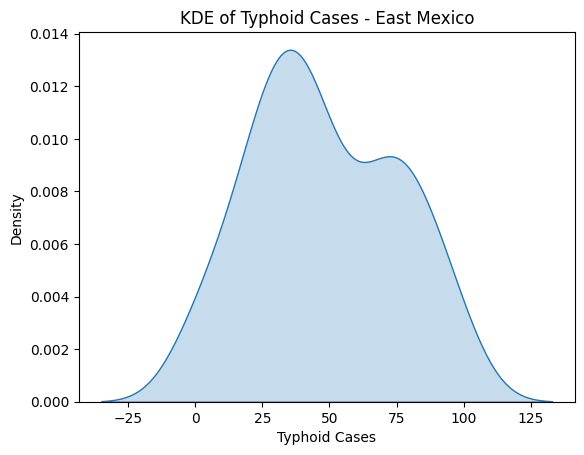

In [29]:
sns.kdeplot(mexico_df[mexico_df['Region']=='East']['Typhoid Cases per 100,000 people'], fill=True)
plt.title('KDE of Typhoid Cases - East Mexico')
plt.xlabel('Typhoid Cases')
plt.show()

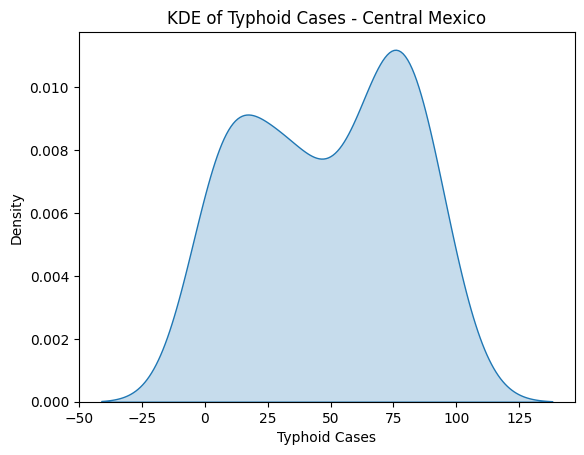

In [30]:
sns.kdeplot(mexico_df[mexico_df['Region']=='Central']['Typhoid Cases per 100,000 people'], fill=True)
plt.title('KDE of Typhoid Cases - Central Mexico')
plt.xlabel('Typhoid Cases')
plt.show()

### Conclusion
##### The shapiro-wilk test indicated that all regions but east showed non-normal distributions with pvals<0.05, justifying the use of the kruskal-wallis test. The kruskal-wallis test showed no significant diffrence in the distribution of typhoid cases across the regions at 5% significance level. Although visual discrepancies are present, they are not supported by statistical evidence.

### Regional Distribution of Diarrheal Cases in Mexico

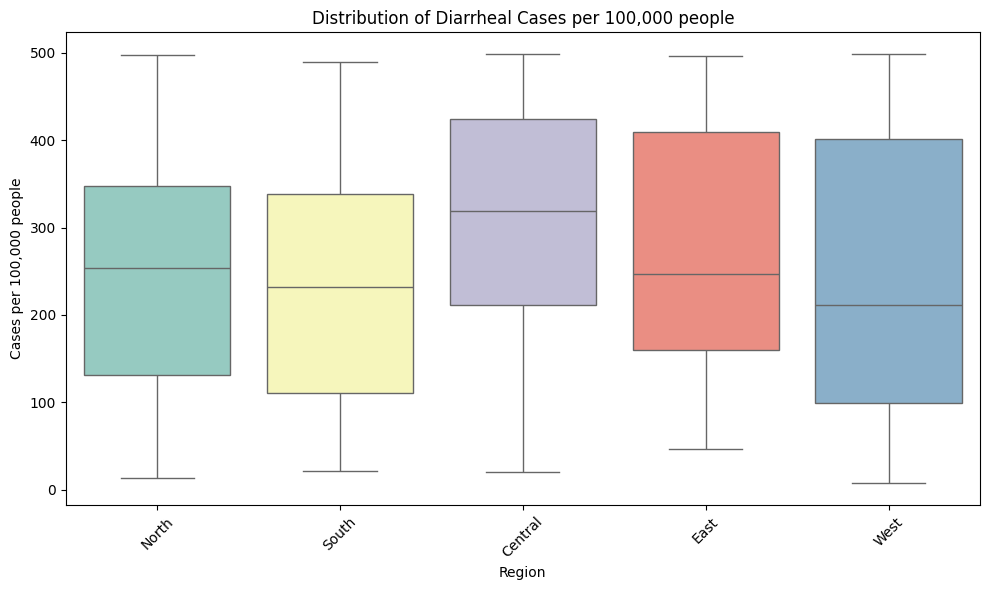

In [31]:
plt.figure(figsize=(10,6))
sns.boxplot(data=mexico_df, x='Region', y='Diarrheal Cases per 100,000 people', palette='Set3')
plt.title('Distribution of Diarrheal Cases per 100,000 people')
plt.xlabel('Region')
plt.ylabel('Cases per 100,000 people')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [32]:
regions= mexico_df['Region'].unique()
print('Shapiro-Wilk test by region:')
for region in regions:
    regional_data= mexico_df[mexico_df['Region']==region]['Diarrheal Cases per 100,000 people']
    stat, p= shapiro(regional_data)
    print(f'{region:<10} - Statistic: {stat:.4f}, p-value: {p:.4f}')

grouped_data= [mexico_df[mexico_df['Region']== region]['Diarrheal Cases per 100,000 people'] for region in regions]

kruskal_stat, kruskal_p= kruskal(*grouped_data)
print(f'\nKruskal_Wallis test:')
print(f'Statistic: {kruskal_stat:.4f}, p-value: {kruskal_p:.4f}')

Shapiro-Wilk test by region:
North      - Statistic: 0.9637, p-value: 0.0600
South      - Statistic: 0.9444, p-value: 0.0287
Central    - Statistic: 0.9448, p-value: 0.0106
East       - Statistic: 0.9284, p-value: 0.0023
West       - Statistic: 0.9227, p-value: 0.0006

Kruskal_Wallis test:
Statistic: 9.1979, p-value: 0.0563


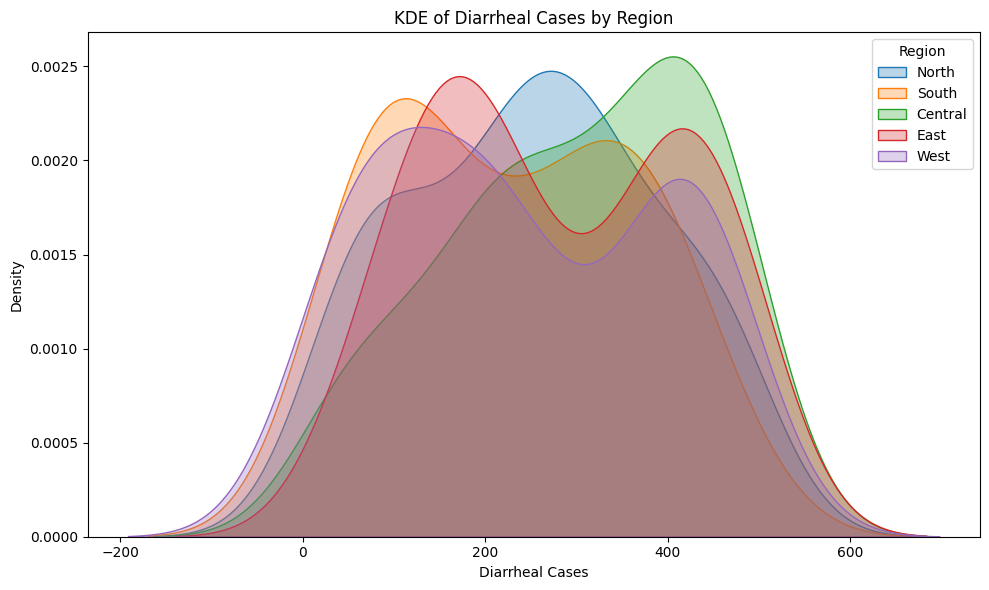

In [33]:
plt.figure(figsize=(10, 6))

# Loop through each region
for region in mexico_df['Region'].unique():
    region_data = mexico_df[mexico_df['Region'] == region]['Diarrheal Cases per 100,000 people']
    sns.kdeplot(region_data, label=region, fill=True, alpha=0.3)

plt.title("KDE of Diarrheal Cases by Region")
plt.xlabel("Diarrheal Cases")
plt.ylabel("Density")
plt.legend(title="Region")
plt.tight_layout()
plt.show()


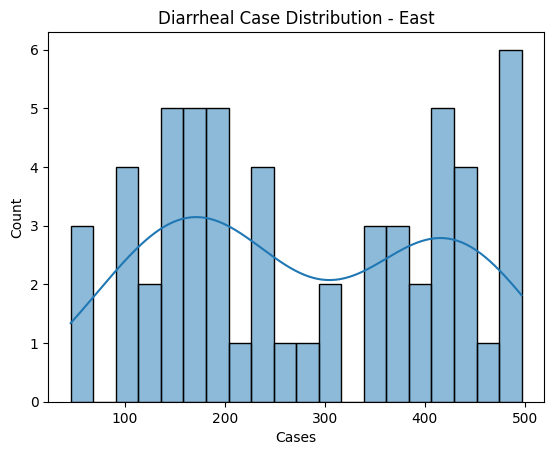

In [34]:
data = mexico_df[mexico_df['Region'] == 'East']['Diarrheal Cases per 100,000 people']

sns.histplot(data, bins=20, kde=True)
plt.title(f'Diarrheal Case Distribution - East')
plt.xlabel("Cases")
plt.show()

In [35]:
mexico_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 288 entries, 0 to 2999
Data columns (total 24 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Country                                        288 non-null    object 
 1   Region                                         288 non-null    object 
 2   Year                                           288 non-null    int64  
 3   Water Source Type                              288 non-null    object 
 4   Contaminant Level (ppm)                        288 non-null    float64
 5   pH Level                                       288 non-null    float64
 6   Turbidity (NTU)                                288 non-null    float64
 7   Dissolved Oxygen (mg/L)                        288 non-null    float64
 8   Nitrate Level (mg/L)                           288 non-null    float64
 9   Lead Concentration (µg/L)                      288 non-nul

In [36]:
urbanization_by_region= mexico_df.groupby('Region')['Urbanization Rate (%)'].mean().sort_values(ascending=False)
urbanization_by_region

Region
East       50.952632
Central    49.760690
North      48.766349
West       47.539062
South      43.222609
Name: Urbanization Rate (%), dtype: float64

### Temporal Analysis of Diarrheal Cases by Region in Brazil
##### To understand how diarrheal cases change over time, I analyzed the trend of diarrheal case rates by region. The visualization highlights how each region has performed over the years in terms of reducing––or maintaining––its diarrheal rate.

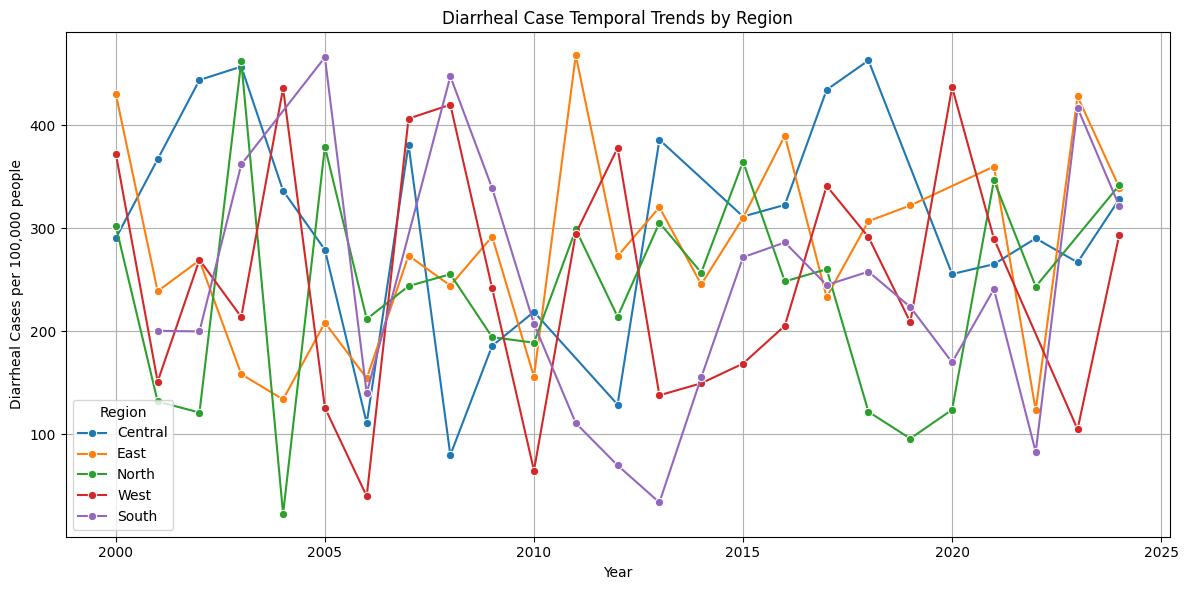

In [37]:
diarrheal_trend= mexico_df.groupby(['Year', 'Region'])['Diarrheal Cases per 100,000 people'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=diarrheal_trend, x='Year', y='Diarrheal Cases per 100,000 people', hue='Region', marker='o', palette= 'tab10')
plt.title('Diarrheal Case Temporal Trends by Region')
plt.xlabel('Year')
plt.ylabel('Diarrheal Cases per 100,000 people')
plt.grid(True)
plt.tight_layout()
plt.legend(title='Region')
plt.show()

### Distribution of Infant Mortality Rate Across Mexico

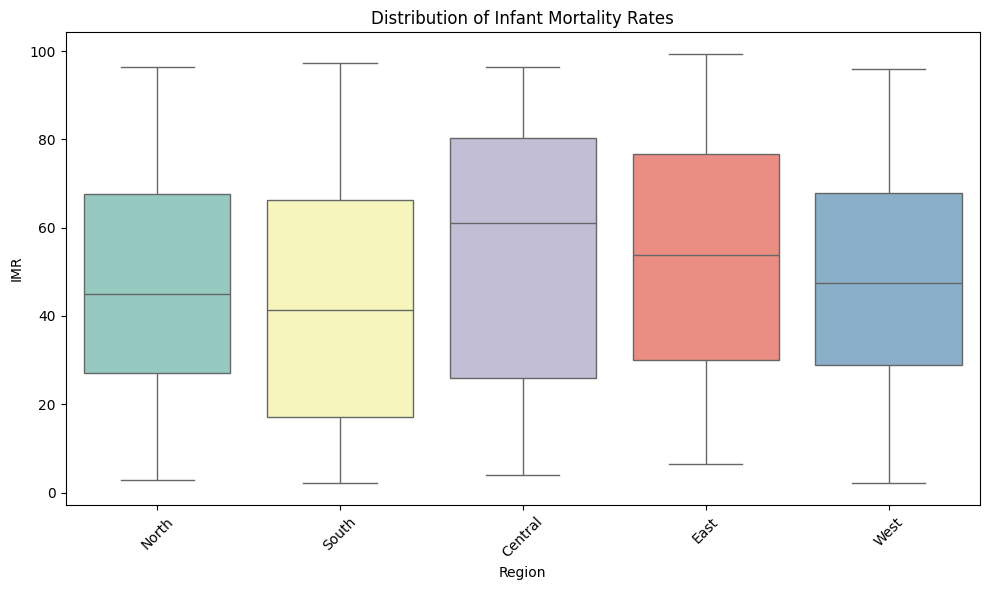

In [38]:
plt.figure(figsize=(10,6))
sns.boxplot(data=mexico_df, x='Region', y='Infant Mortality Rate (per 1,000 live births)', palette='Set3')
plt.title('Distribution of Infant Mortality Rates')
plt.xlabel('Region')
plt.ylabel('IMR')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [39]:
regions= mexico_df['Region'].unique()
print('Shapiro-Wilk test by region:')
for region in regions:
    regional_data= mexico_df[mexico_df['Region']==region]['Infant Mortality Rate (per 1,000 live births)']
    stat, p= shapiro(regional_data)
    print(f'{region:<10} - Statistic: {stat:.4f}, p-value: {p:.4f}')

grouped_data= [mexico_df[mexico_df['Region']== region]['Infant Mortality Rate (per 1,000 live births)'] for region in regions]

kruskal_stat, kruskal_p= kruskal(*grouped_data)
print(f'\nKruskal_Wallis test:')
print(f'Statistic: {kruskal_stat:.4f}, p-value: {kruskal_p:.4f}')

Shapiro-Wilk test by region:
North      - Statistic: 0.9638, p-value: 0.0605
South      - Statistic: 0.9294, p-value: 0.0080
Central    - Statistic: 0.9198, p-value: 0.0009
East       - Statistic: 0.9512, p-value: 0.0224
West       - Statistic: 0.9649, p-value: 0.0657

Kruskal_Wallis test:
Statistic: 5.5002, p-value: 0.2397


### Conclusion
##### The shapiro-wilk test shows that the distribution of imrs were non-normal except for the North and West, supporting the decision to use the kruskal-wallis test. The wallis test returned a pvalue of 0.2397 suggesting there is not enough evidence to conclude the distributions differ from each other. 

### Temporal Analysis of IMRs by Region in Mexico
##### To understand how infant health outcomes have evolved across different parts of Mexico, I analyzed the tempral trend of IMRs by region.

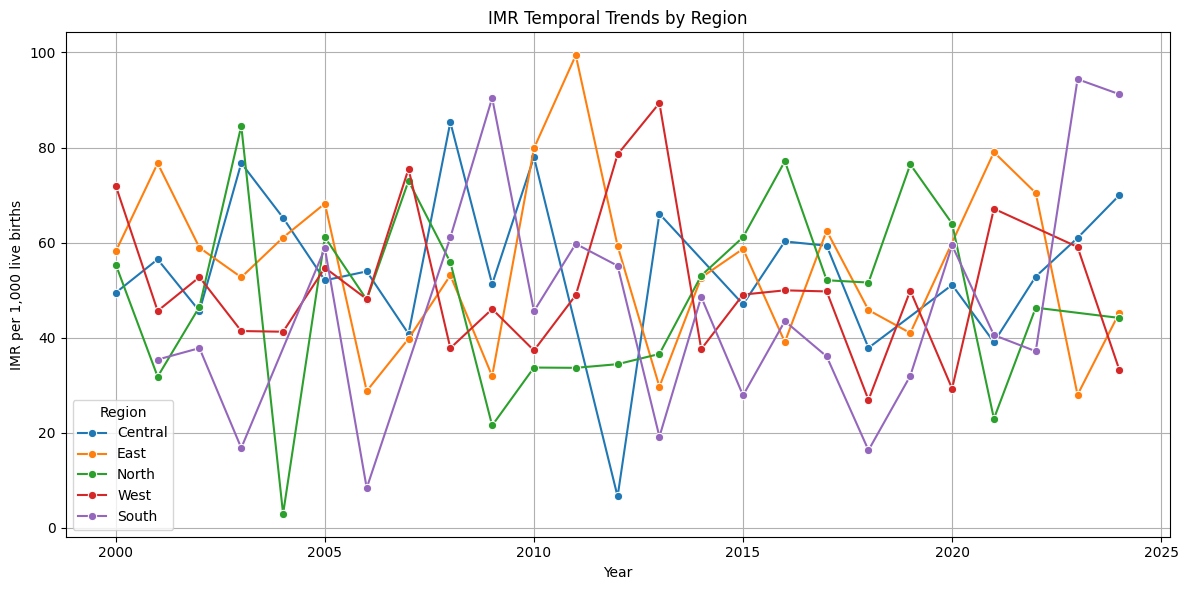

In [40]:
imr_trend= mexico_df.groupby(['Year', 'Region'])['Infant Mortality Rate (per 1,000 live births)'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=imr_trend, x='Year', y='Infant Mortality Rate (per 1,000 live births)', hue='Region', marker='o', palette= 'tab10')
plt.title('IMR Temporal Trends by Region')
plt.xlabel('Year')
plt.ylabel('IMR per 1,000 live births')
plt.grid(True)
plt.tight_layout()
plt.legend(title='Region')
plt.show()

In [41]:
regions= imr_trend['Region'].unique()
for region in regions:
    region_data= imr_trend[imr_trend['Region']==region]
    slope, _,_,_,_= linregress(region_data['Year'], region_data['Infant Mortality Rate (per 1,000 live births)'])
    print(f'{region} IMR trend slope: {slope:.4f}') 

Central IMR trend slope: -0.1741
East IMR trend slope: -0.3746
North IMR trend slope: 0.2155
West IMR trend slope: -0.3264
South IMR trend slope: 0.9816


### Conclusion
##### Most of the regions have experienced a general decline in IMR, which implies that health conditions and infrastructure has improved. However, the South IMR has drastically increased with a slope of 0.9816, which deserves a deeper visualization and analysis in comparison with the East of -0.3746.

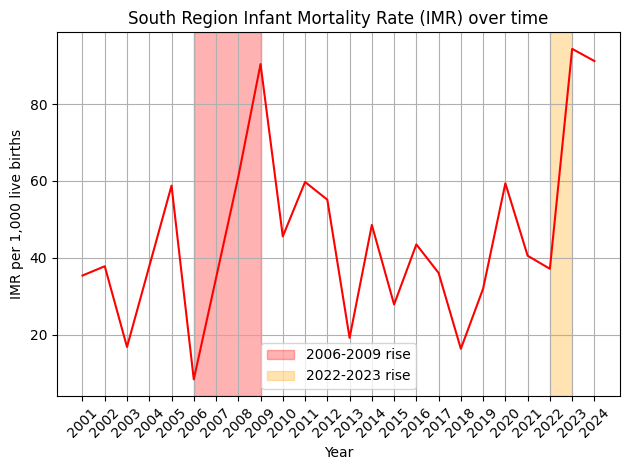

In [42]:
south_imr= mexico_df[mexico_df['Region']=='South'][['Year', 'Infant Mortality Rate (per 1,000 live births)']]
sns.lineplot(data=south_imr, x='Year', y='Infant Mortality Rate (per 1,000 live births)', color= 'red',ci=None)
plt.title('South Region Infant Mortality Rate (IMR) over time')
plt.ylabel('IMR per 1,000 live births')
plt.xlabel('Year')
plt.xticks(ticks=range(south_imr['Year'].min(), south_imr['Year'].max()+1), rotation=45)
plt.tight_layout()
plt.grid(True)
plt.axvspan(2006, 2009, color='red', alpha=0.3, label='2006-2009 rise')
plt.axvspan(2022, 2023, color='orange', alpha=0.3, label='2022-2023 rise')
plt.legend()
plt.show()

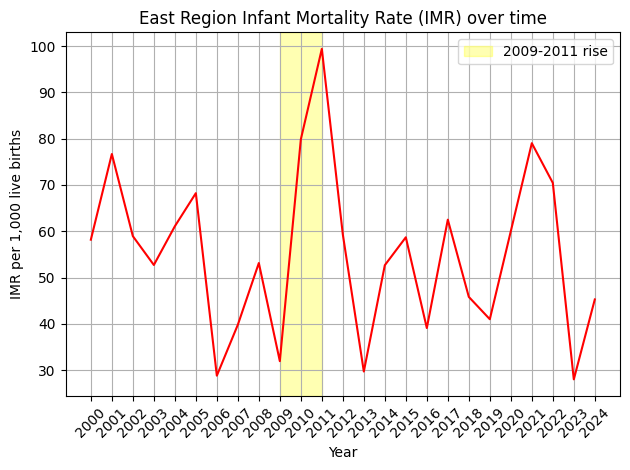

In [43]:
east_imr= mexico_df[mexico_df['Region']=='East'][['Year', 'Infant Mortality Rate (per 1,000 live births)']]
sns.lineplot(data=east_imr, x='Year', y='Infant Mortality Rate (per 1,000 live births)', color= 'red',ci=None)
plt.title('East Region Infant Mortality Rate (IMR) over time')
plt.ylabel('IMR per 1,000 live births')
plt.xlabel('Year')
plt.xticks(ticks=range(east_imr['Year'].min(), east_imr['Year'].max()+1), rotation=45)
plt.tight_layout()
plt.grid(True)
plt.axvspan(2009, 2011, color='yellow', alpha=0.3, label='2009-2011 rise')
plt.legend()
plt.show()

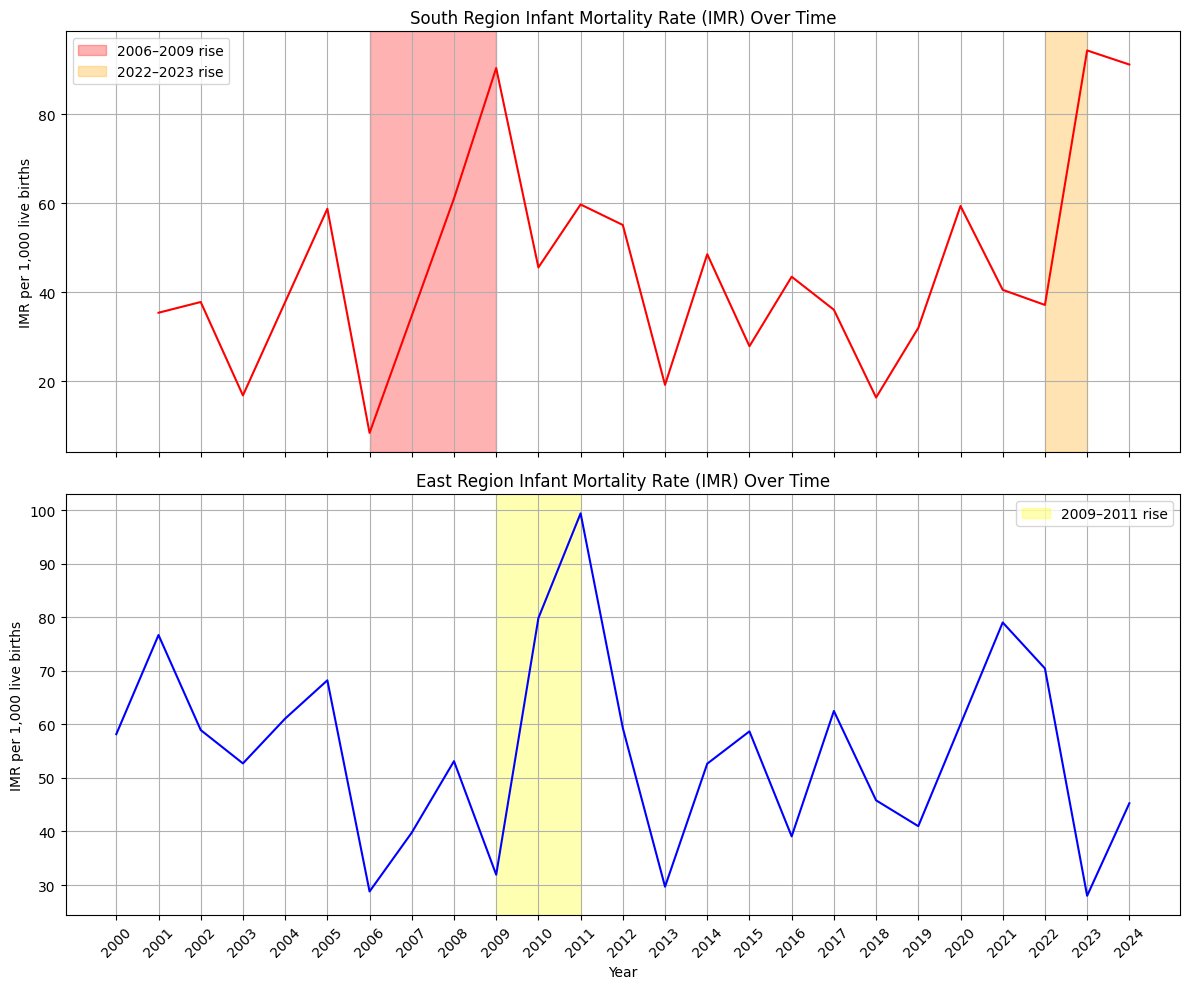

In [44]:
south_imr = mexico_df[mexico_df['Region'] == 'South'][['Year', 'Infant Mortality Rate (per 1,000 live births)']]
east_imr = mexico_df[mexico_df['Region'] == 'East'][['Year', 'Infant Mortality Rate (per 1,000 live births)']]

fig, axes = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

sns.lineplot(data=south_imr, x='Year', y='Infant Mortality Rate (per 1,000 live births)', color='red', ci=None, ax=axes[0])
axes[0].set_title('South Region Infant Mortality Rate (IMR) Over Time')
axes[0].set_ylabel('IMR per 1,000 live births')
axes[0].grid(True)
axes[0].axvspan(2006, 2009, color='red', alpha=0.3, label='2006–2009 rise')
axes[0].axvspan(2022, 2023, color='orange', alpha=0.3, label='2022–2023 rise')
axes[0].legend()

# East IMR plot
sns.lineplot(data=east_imr, x='Year', y='Infant Mortality Rate (per 1,000 live births)', color='blue', ci=None, ax=axes[1])
axes[1].set_title('East Region Infant Mortality Rate (IMR) Over Time')
axes[1].set_ylabel('IMR per 1,000 live births')
axes[1].set_xlabel('Year')
axes[1].grid(True)
axes[1].axvspan(2009, 2011, color='yellow', alpha=0.3, label='2009–2011 rise')
axes[1].legend()

# Shared x-axis ticks
years = range(min(south_imr['Year'].min(), east_imr['Year'].min()),
              max(south_imr['Year'].max(), east_imr['Year'].max()) + 1)
axes[1].set_xticks(years)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [45]:
def slope_for_period(df, start, end):
    period = df[(df['Year'] >= start) & (df['Year'] <= end)]
    slope, _, _, _, _ = linregress(period['Year'], period['Infant Mortality Rate (per 1,000 live births)'])
    return slope

south_df = south_imr.copy()
east_df = east_imr.copy()

def test_pattern(south_data, east_data):
    south_slope_06_09 = slope_for_period(south_data, 2006, 2009)
    south_slope_10_14 = slope_for_period(south_data, 2010, 2014)  
    east_slope_09_11 = slope_for_period(east_data, 2009, 2011)

    return (south_slope_06_09 > 0) and (south_slope_10_14 < 0) and (east_slope_09_11 > 0)

observed = test_pattern(south_df, east_df)


n_perm = 1000
count = 0

for _ in range(n_perm):
    south_shuffled = south_df.copy()
    south_shuffled['Year'] = np.random.permutation(south_shuffled['Year'].values)
    east_shuffled = east_df.copy()
    east_shuffled['Year'] = np.random.permutation(east_shuffled['Year'].values)

    if test_pattern(south_shuffled, east_shuffled):
        count += 1

p_value = count / n_perm
print(f"P-value for pattern happening by chance: {p_value}")


P-value for pattern happening by chance: 0.117


### Conclusion
##### There was a major spike in IMR between 2006 and 2009 in the south region of Mexico and another between 2022 and 2023. Both are most likely due to socioeconomic factors, so I will compare them with other variables such as GDP per capita. In comparison to the east region, just as the south region started to decline, the east region's imr drastically increased, suggesting one may have affected the other. However, when running a permutation test, it resulted in a p-value of 0.107 which means there isn't enough evidence to conclude that one caused the other.

In [46]:
region_dfs = {region: mexico_df[mexico_df['Region'] == region] for region in ['West', 'South', 'East', 'North', 'Central']}
mexico_df_agg= mexico_df.groupby('Region')['GDP per Capita (USD)'].describe()

In [47]:
mexico_df_agg

,count,mean,std,min,25%,50%,75%,max
Region,,,,,,,,
Central,58.0,53848.068966,29953.019192,1278.0,26563.25,51015.0,83986.25,99948.0
East,57.0,41393.298246,27796.171200,1787.0,19491.00,34435.0,58126.00,99007.0
North,63.0,46244.698413,29267.111312,2413.0,20686.00,49598.0,67665.00,95318.0
South,46.0,56619.717391,29890.883590,3884.0,27453.75,55691.0,86615.50,98390.0
West,64.0,49565.421875,27207.935997,6013.0,22709.00,50622.5,69579.75,98696.0


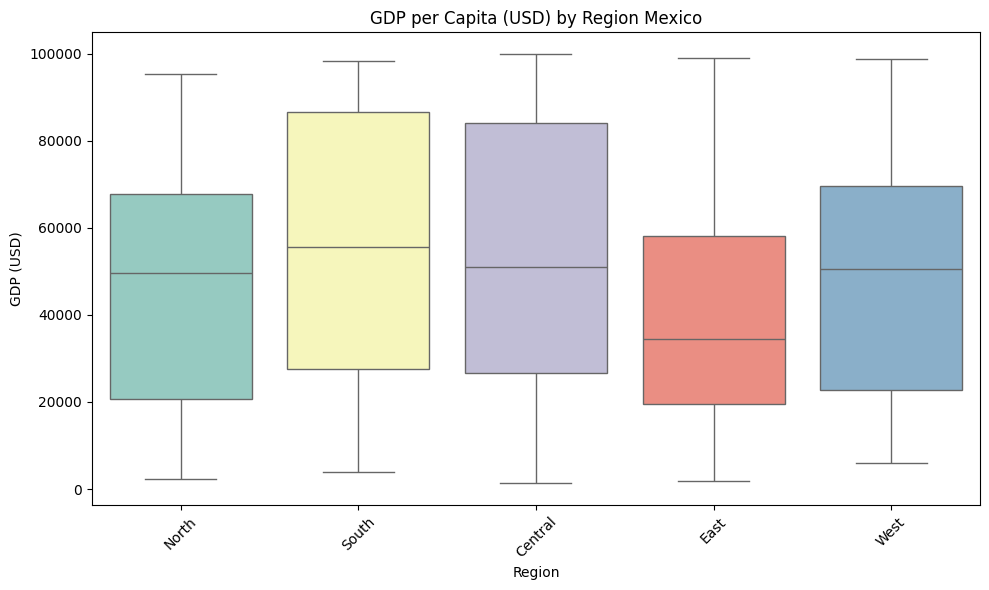

In [48]:
plt.figure(figsize=(10,6))
sns.boxplot(data=mexico_df, x='Region', y='GDP per Capita (USD)', palette ='Set3')
plt.title('GDP per Capita (USD) by Region Mexico')
plt.xlabel('Region')
plt.ylabel('GDP (USD)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Conclusion
##### Since the south had the spikes in IMR I will also do a temporal analysis of the GDP in the south.

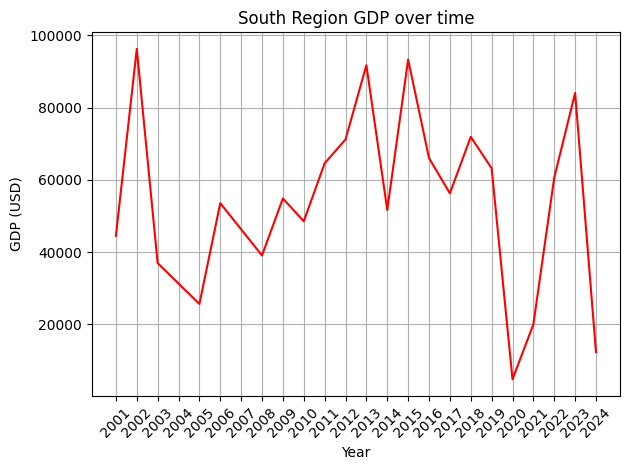

South GDP trend slope: -344.0325


In [49]:
south_gdp= mexico_df[mexico_df['Region']=='South'][['Year', 'GDP per Capita (USD)']]
sns.lineplot(data=south_gdp, x='Year', y='GDP per Capita (USD)', color= 'red',ci=None)
plt.title('South Region GDP over time')
plt.ylabel('GDP (USD)')
plt.xlabel('Year')
plt.xticks(ticks=range(south_gdp['Year'].min(), south_gdp['Year'].max()+1), rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()
slope, _,_,_,_= linregress(south_gdp['Year'], south_gdp['GDP per Capita (USD)'])
print(f'South GDP trend slope: {slope:.4f}') 

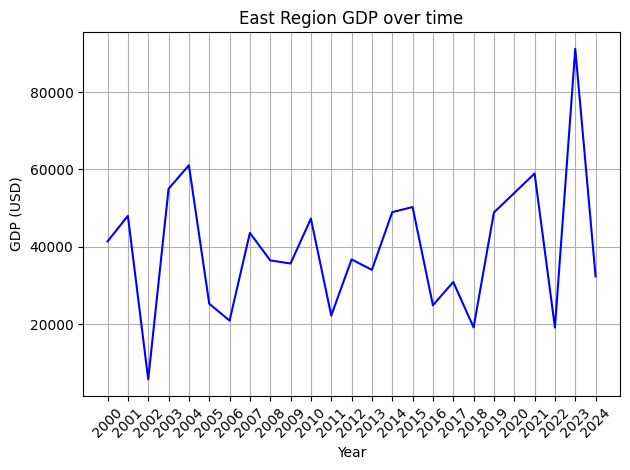

Slope of East GDP trendline is 470.29


In [50]:
east_gdp= mexico_df[mexico_df['Region']=='East'][['Year', 'GDP per Capita (USD)']]
sns.lineplot(data=east_gdp, x='Year', y='GDP per Capita (USD)', color= 'blue',ci=None)
plt.title('East Region GDP over time')
plt.ylabel('GDP (USD)')
plt.xlabel('Year')
plt.xticks(ticks=range(east_gdp['Year'].min(), east_gdp['Year'].max()+1), rotation=45)
plt.tight_layout()
plt.grid(True)
plt.show()
x= east_gdp['Year']
y= east_gdp['GDP per Capita (USD)']
slope, intercept= np.polyfit(x,y,1)
print(f'Slope of East GDP trendline is {slope:.2f}')


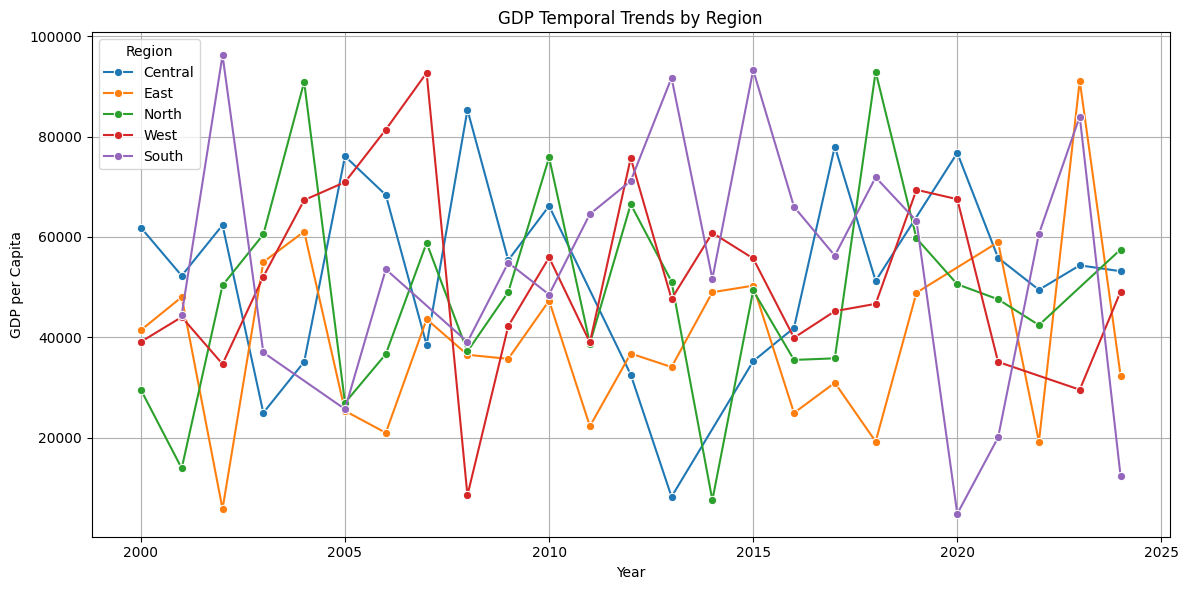

Central - Slope: 22.19, p-value: 0.9683
East - Slope: 376.05, p-value: 0.4741
North - Slope: 443.76, p-value: 0.4728
West - Slope: -241.44, p-value: 0.6657
South - Slope: -340.09, p-value: 0.6751


In [51]:
gdp_trend= mexico_df.groupby(['Year', 'Region'])['GDP per Capita (USD)'].mean().reset_index()

plt.figure(figsize=(12,6))
sns.lineplot(data=gdp_trend, x='Year', y='GDP per Capita (USD)', hue='Region', marker='o', palette= 'tab10')
plt.title('GDP Temporal Trends by Region')
plt.xlabel('Year')
plt.ylabel('GDP per Capita')
plt.grid(True)
plt.tight_layout()
plt.legend(title='Region')
plt.show()
regions= gdp_trend['Region'].unique()
for region in regions:
    region_data= gdp_trend[gdp_trend['Region']==region]
    x = region_data['Year']
    y = region_data['GDP per Capita (USD)']
    
    slope, _, _, p_value, _ = linregress(x, y)
    print(f"{region} - Slope: {slope:.2f}, p-value: {p_value:.4f}")

### Conclusion
##### I calculated the temporal trend line slope of each region's gdp, however each with significantly high pvals. This means that the data is random and year-to-year gdp fluctuates making the trendline slope very weak. I will test the gdp between the south and east regions since they had drastic differences in infant mortality rate.

In [52]:
shapiro_south= shapiro(mexico_df[mexico_df['Region']=='South']['GDP per Capita (USD)'])
shapiro_east= shapiro(mexico_df[mexico_df['Region']=='East']['GDP per Capita (USD)'])
print(f'South - Statistic: {shapiro_south.statistic:.3f}, p-value: {shapiro_south.pvalue:.3f}')
print(f'East  - Statistic: {shapiro_east.statistic:.3f}, p-value: {shapiro_east.pvalue:.3f}')

South - Statistic: 0.903, p-value: 0.001
East  - Statistic: 0.941, p-value: 0.008


In [53]:
u_test= mannwhitneyu(mexico_df[mexico_df['Region']=='South']['GDP per Capita (USD)'],mexico_df[mexico_df['Region']=='East']['GDP per Capita (USD)'], alternative='two-sided')
print(f'Mann-Whitney U - Statistic: {u_test.statistic:.3f}, p-value: {u_test.pvalue:.3f}')

Mann-Whitney U - Statistic: 1684.000, p-value: 0.013


### Conclusion
##### To test if the distributions of the east and south are normal I used to the shapiro-wilk test. Both revealed they they are not normal, which prompted the use of the mann-whitney U test. The test resulted in a very low pvalue which means the distributions of the south and east differ. Below is a visualization

Text(0, 0.5, 'Density')

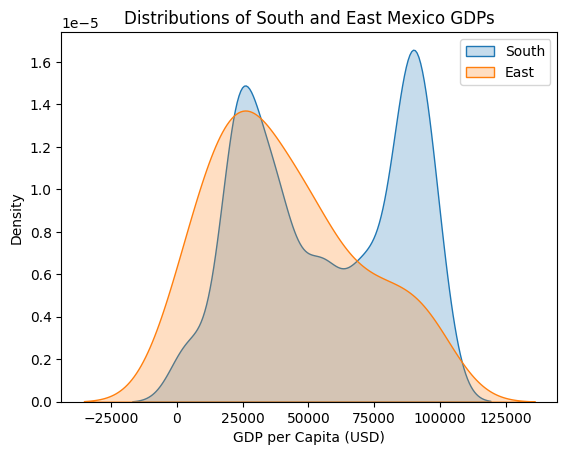

In [54]:
sns.kdeplot(data=mexico_df[mexico_df['Region']=='South'], x='GDP per Capita (USD)', label='South', bw_adjust= 0.5, shade=True)
sns.kdeplot(data=mexico_df[mexico_df['Region']=='East'], x='GDP per Capita (USD)', label='East', shade=True)
plt.legend()
plt.title('Distributions of South and East Mexico GDPs')
plt.ylabel('Density')

### Conclusion
##### The south's gdp is potentially bimodal (two peaks) signifying that there may have been a socioeconomic shift at some time. Below, I created two time periods to help analyze the shift more closely.

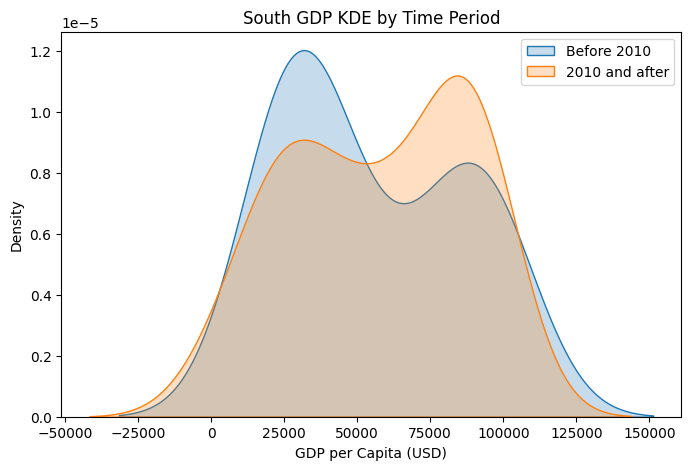

Skewness of South GDP before 2010: 0.331
Skewness of South GDP 2010 and after: -0.221


In [55]:
from scipy.stats import skew
south_before_2010 = mexico_df[(mexico_df['Region']=='South') & (mexico_df['Year'] < 2010)]['GDP per Capita (USD)']
south_after_2010 = mexico_df[(mexico_df['Region']=='South') & (mexico_df['Year'] >= 2010)]['GDP per Capita (USD)']

plt.figure(figsize=(8,5))
sns.kdeplot(south_before_2010, shade=True, label='Before 2010')
sns.kdeplot(south_after_2010, shade=True, label='2010 and after')
plt.title('South GDP KDE by Time Period')
plt.xlabel('GDP per Capita (USD)')
plt.ylabel('Density')
plt.legend()
plt.show()

skew_before= skew(south_before_2010)
skew_after= skew(south_after_2010)
print(f"Skewness of South GDP before 2010: {skew_before:.3f}")
print(f"Skewness of South GDP 2010 and after: {skew_after:.3f}")

### Conclusion
##### It is clear that there was a significant shift in GDP distribution from before 2010 to after 2010. I decided to calculate skweness to quantify the shift, so before 2010 it was 0.331 which means much of the GDP per Capital lies in the lower quartile with high outliers, while after 2010 it flips with higher in the upper quartile with some lower outliers. Below I conduct a mannwhitney u test to confirm the difference in distributions between the two time periods in the south region of mexico.

In [56]:
stat, p= mannwhitneyu(south_before_2010, south_after_2010, alternative='two-sided')
print(f'Mann-Whitney U test Statistic: {stat:.3f}')
print(f'p-value: {p:.3f}')

Mann-Whitney U test Statistic: 223.000
p-value: 0.833


### Conclusion
##### After conduction the Mann whitney U test, we can conclude that there is no statistically signficant difference (p=0.833>0.05) between the distributions in the time periods. The difference between the south's imr and east's imr may lie due to other socioeconomic factors such as access to clean water and sanitation rate.

In [57]:
mexico_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 288 entries, 0 to 2999
Data columns (total 24 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Country                                        288 non-null    object 
 1   Region                                         288 non-null    object 
 2   Year                                           288 non-null    int64  
 3   Water Source Type                              288 non-null    object 
 4   Contaminant Level (ppm)                        288 non-null    float64
 5   pH Level                                       288 non-null    float64
 6   Turbidity (NTU)                                288 non-null    float64
 7   Dissolved Oxygen (mg/L)                        288 non-null    float64
 8   Nitrate Level (mg/L)                           288 non-null    float64
 9   Lead Concentration (µg/L)                      288 non-nul

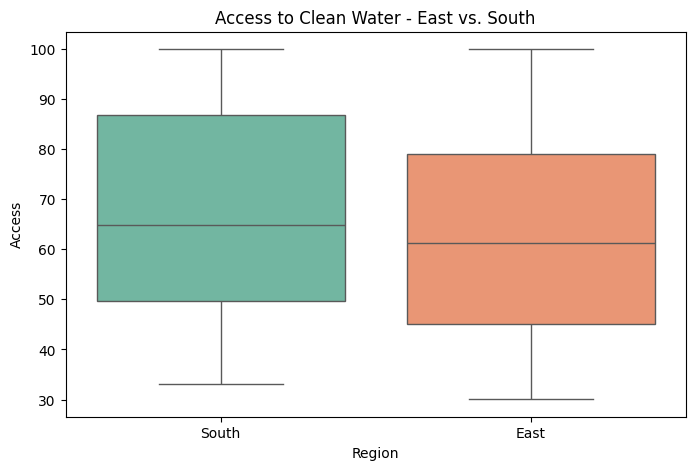

In [58]:
plt.figure(figsize=(8,5))
sns.boxplot(data=mexico_df[mexico_df['Region'].isin(['South','East'])], x='Region', y='Access to Clean Water (% of Population)', palette='Set2')
plt.title('Access to Clean Water - East vs. South')
plt.ylabel('Access')
plt.xlabel('Region')
plt.show()

In [59]:
stat_south, p_south= shapiro(mexico_df[mexico_df['Region']=='South']['Access to Clean Water (% of Population)'])
stat_east, p_east= shapiro(mexico_df[mexico_df['Region']=='East']['Access to Clean Water (% of Population)'])

print(f'South stat: {stat_south:.3f}, p-value: {p_south:.3f}')
print(f'East stat: {stat_east:.3f}, p-value: {p_east:.3f}')


South stat: 0.933, p-value: 0.011
East stat: 0.942, p-value: 0.008


In [60]:
stat_mw, p_mw= mannwhitneyu(mexico_df[mexico_df['Region']=='South']['Access to Clean Water (% of Population)'],mexico_df[mexico_df['Region']=='East']['Access to Clean Water (% of Population)'], alternative='two-sided')
print(f'Mann whitney U stat: {stat_mw:.3f}, p-value: {p_mw:.3f}')

Mann whitney U stat: 1475.000, p-value: 0.278


### Conclusion
##### The shapiro-wilk test results show that the distributions for both East (p=0.008) and South (p=0.011) regions significantly deviate from normality. Due to non-normality, I used the mann whitney u test to assess differences in distribution between the two. With (p=0.278), there is no significant difference in their distributions. People in the East and South appear to have similar levels of sanitation coverage.

In [61]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
scaler= StandardScaler()
mexico_scaled= scaler.fit_transform(mexico_df.select_dtypes(include='number'))

pca= PCA(n_components=2)
principal_components= pca.fit_transform(mexico_scaled)
pca_df= pd.DataFrame(data= principal_components, columns=['PC1', 'PC2', 'PC3'])

plt.figure(figsize=(10,6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2')
plt.title('PCA of Socio-Health Variables')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
plt.grid(True)
plt.tight_layout()
pca_df['Region'] = mexico_df['Region'].values[:len(pca_df)]  # match rows
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Region')
plt.show()

print("Explained variance ratio:", pca.explained_variance_ratio_)
print("Cumulative variance explained:", pca.explained_variance_ratio_.cumsum())

ValueError: Shape of passed values is (288, 2), indices imply (288, 3)

Cumulative variance explained: [0.07399997 0.14480616 0.21262061 0.27618673 0.33845013 0.39882532
 0.45543893 0.5096642  0.56281243 0.61318142 0.66032411 0.70675861
 0.75110263 0.79344456 0.83421874 0.87323302 0.90719084 0.94005244
 0.97036345 1.        ]


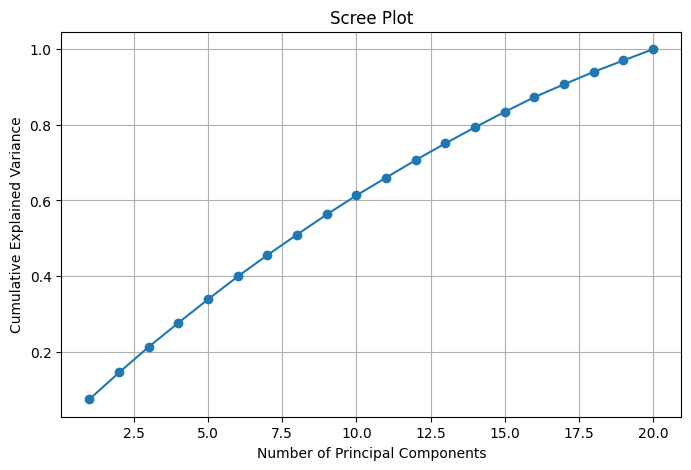

In [68]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Assuming X is your numeric data matrix (after scaling)

pca = PCA()  # No n_components specified means keep all PCs
pca.fit(mexico_scaled)

# Explained variance ratio for all PCs
explained_variance = pca.explained_variance_ratio_

# Cumulative explained variance
cumulative_variance = np.cumsum(explained_variance)

# Print or inspect cumulative variance
print("Cumulative variance explained:", cumulative_variance)

# Scree plot to visualize how many PCs explain most variance
plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_variance)+1), cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Scree Plot')
plt.grid(True)
plt.show()
